In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import modules
import ddsp_textures.loss.functions
import ddsp_textures.auxiliar.filterbanks

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire_sounds/fire.wav"
water_path = ".."+"/sounds/water_sounds/water.wav"
sr     = 44100
new_sr = sr // 4 # for log_bank
fire_audio, _  = librosa.load(fire_path, sr=sr)
water_audio, _ = librosa.load(water_path, sr=sr)
# Make list of segments for fire and water --------------
frame_size     = 2**16
new_frame_size = frame_size // 4
hop_size   = 2**16
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    fire_segments.append(fire_audio[i:i+frame_size])
for i in range(0, len(water_audio)-frame_size, hop_size):
    water_segments.append(water_audio[i:i+frame_size])
# Initialize erb_bank and log_bank for statistics loss --
N_filter_bank = 20
M_filter_bank = 10
erb_bank    = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
log_bank    = ddsp_textures.auxiliar.filterbanks.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)
import torchaudio
downsampler = torchaudio.transforms.Resample(sr, new_sr)

In [11]:
#Testing Statistics functions --------------------------------------------------

fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
water_segment = water_segments[np.random.randint(len(water_segments))]
fire_segment  = torch.tensor(fire_segment)
water_segment = torch.tensor(water_segment)
fire_stats  = ddsp_textures.loss.functions.statistics(fire_segment,  N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
water_stats = ddsp_textures.loss.functions.statistics(water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
print("Fire statistics:\n")
print("stats_1:\n", fire_stats[0])
print("stats_2:\n", fire_stats[1])
print("stats_3:\n", fire_stats[2])
print("stats_4:\n", fire_stats[3])
print("stats_5:\n", fire_stats[4])
print("Water statistics:\n")
print("stats_1:\n", water_stats[0])
print("stats_2:\n", water_stats[1])
print("stats_3:\n", water_stats[2])
print("stats_4:\n", water_stats[3])
print("stats_5:\n", water_stats[4])

Fire statistics:

stats_1:
 tensor([[5.6410e+00, 3.6431e-01, 1.5213e-02, 6.2510e-03],
        [2.2197e+00, 3.4267e-01, 2.1250e-02, 8.3765e-03],
        [6.5930e-01, 3.2636e-01, 1.7025e-02, 8.0429e-03],
        [2.5910e-01, 3.1311e-01, 2.2045e-02, 1.0678e-02],
        [1.9479e-01, 8.0273e-01, 8.1673e-02, 5.2642e-02],
        [2.1027e-01, 1.1737e+00, 1.2501e-01, 1.1942e-01],
        [1.6681e-01, 2.5009e+00, 1.5467e-01, 1.5759e-01],
        [1.6879e-01, 1.2605e+01, 2.9439e-01, 5.3445e-01],
        [1.2136e-01, 1.1727e+01, 2.8928e-01, 5.5429e-01],
        [1.1079e-01, 1.3009e+01, 2.8007e-01, 5.1080e-01],
        [9.9821e-02, 1.3112e+01, 2.8170e-01, 5.4313e-01],
        [8.0422e-02, 8.9429e+00, 2.0637e-01, 2.6945e-01],
        [6.8842e-02, 1.0030e+01, 2.7828e-01, 5.0626e-01],
        [9.2490e-02, 1.4855e+01, 2.5048e-01, 3.7083e-01],
        [9.7082e-02, 1.2526e+01, 3.2525e-01, 7.3259e-01],
        [1.1755e-01, 1.4338e+01, 3.9917e-01, 1.0803e+00],
        [1.3659e-01, 2.8994e+01, 5.6482e-01,

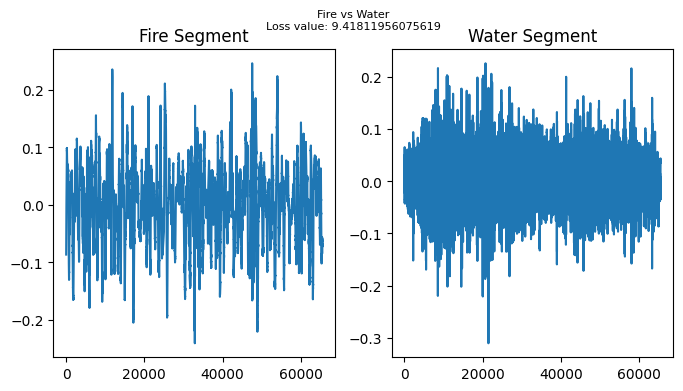

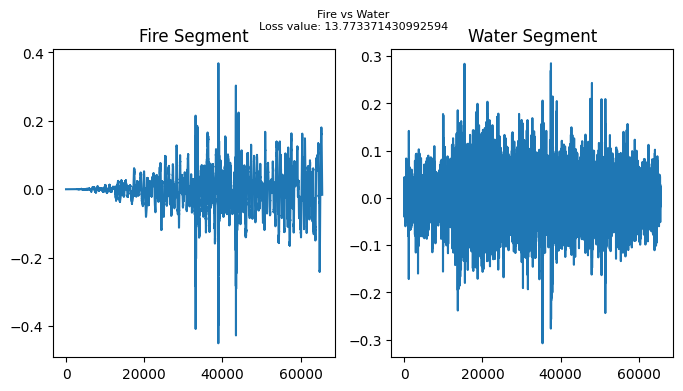

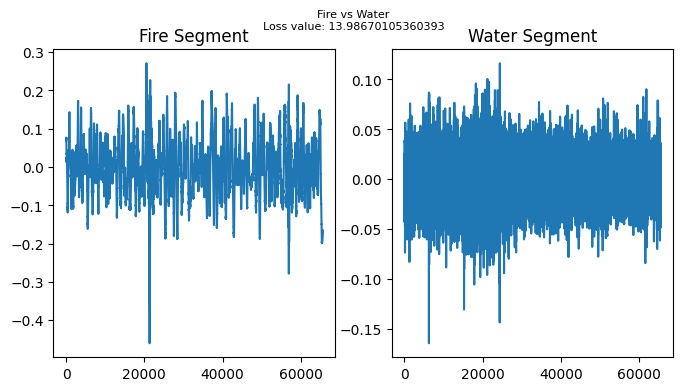

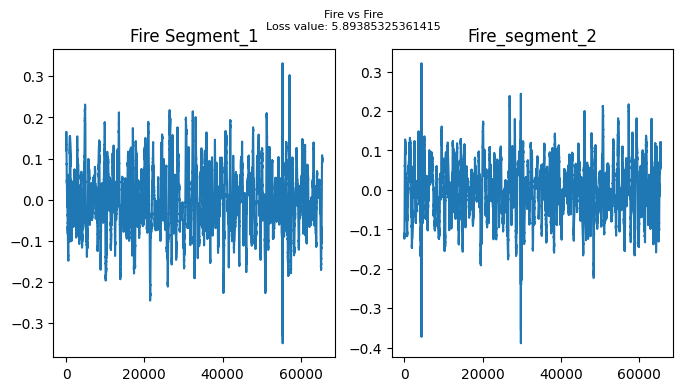

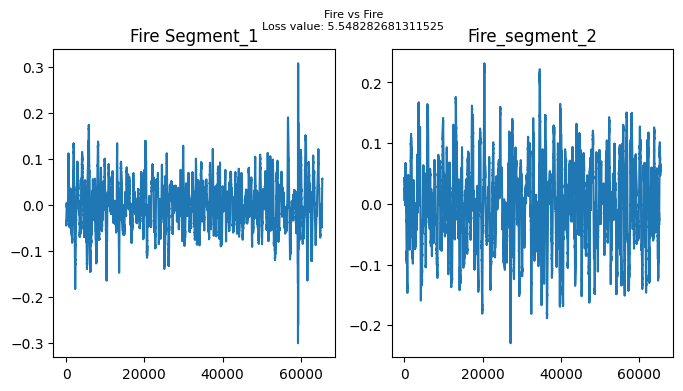

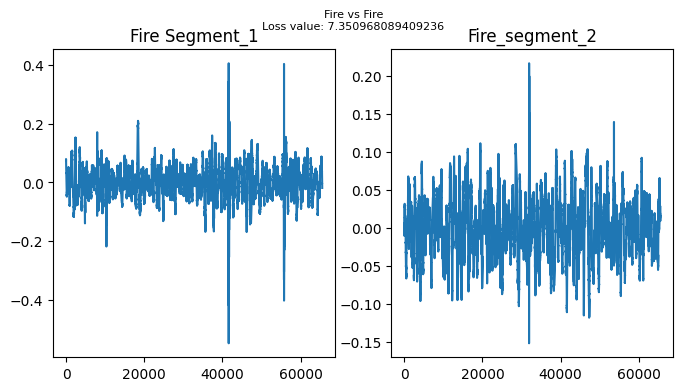

In [12]:
# Test Statistics loss function on three random pair of segments and plot them
for i in range(3):
    fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
    water_segment = water_segments[np.random.randint(len(water_segments))]
    fire_segment  = torch.tensor(fire_segment)
    #play water and fire segments
    display(Audio(fire_segment, rate=sr))
    display(Audio(water_segment, rate=sr))
    water_segment = torch.tensor(water_segment)
    loss_value = ddsp_textures.loss.functions.statistics_loss(fire_segment, water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(fire_segment)
    ax1.set_title('Fire Segment')
    ax2.plot(water_segment)
    ax2.set_title('Water Segment')
    fig.suptitle(f'Fire vs Water\nLoss value: {loss_value}', fontsize=8)
    plt.show()
# Test Statistics loss function on three random pair of fair
for i in range(3):
    fire_segment_1 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_2 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_1 = torch.tensor(fire_segment_1)
    fire_segment_2 = torch.tensor(fire_segment_2)
    #play water and fire segments
    display(Audio(fire_segment_1, rate=sr))
    display(Audio(fire_segment_2, rate=sr))
    loss_value = ddsp_textures.loss.functions.statistics_loss(fire_segment_1, fire_segment_2, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(fire_segment_1)
    ax1.set_title('Fire Segment_1')
    ax2.plot(fire_segment_2)
    ax2.set_title('Fire_segment_2')
    fig.suptitle(f'Fire vs Fire\nLoss value: {loss_value}', fontsize=8)
    plt.show()

In [13]:
#Take 16 segments and make a batch
fire_batch = []
for i in range(32):
    fire_segment = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment = torch.tensor(fire_segment)
    fire_batch.append(fire_segment)
fire_batch = torch.stack(fire_batch, dim=0)

water_batch = []
for i in range(32):
    water_segment = water_segments[np.random.randint(len(water_segments))]
    water_segment = torch.tensor(water_segment)
    water_batch.append(water_segment)
water_batch = torch.stack(water_batch, dim=0)

import time
start = time.time()
loss = ddsp_textures.loss.functions.batch_statistics_loss(fire_batch, water_batch, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
end = time.time()
print("Time taken: ", end-start)
print("Batch loss value: ", loss)


Time taken:  15.253867387771606
Batch loss value:  tensor(10.6098, dtype=torch.float64)


In [14]:
# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire_sounds/fire.wav"
water_path = ".."+"/sounds/water_sounds/water.wav"
sr     = 44100
new_sr = sr // 4 # for log_bank
fire_audio, _  = librosa.load(fire_path, sr=sr)
water_audio, _ = librosa.load(water_path, sr=sr)
# Make list of segments for fire and water --------------
frame_size     = 2**16
new_frame_size = frame_size // 4
hop_size   = 2**16
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    fire_segments.append(fire_audio[i:i+frame_size])
for i in range(0, len(water_audio)-frame_size, hop_size):
    water_segments.append(water_audio[i:i+frame_size])
# Initialize erb_bank and log_bank for statistics loss --
N_filter_bank = 20
M_filter_bank = 10
erb_bank    = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
log_bank    = ddsp_textures.auxiliar.filterbanks.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)
import torchaudio

import ddsp_textures.loss
downsampler = torchaudio.transforms.Resample(sr, new_sr)

# pick random segments
fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
water_segment = water_segments[np.random.randint(len(water_segments))]
fire_segment  = torch.tensor(fire_segment)
water_segment = torch.tensor(water_segment)
#play water and fire segments
display(Audio(fire_segment, rate=sr))
display(Audio(water_segment, rate=sr))
# Compute stems
from ddsp_textures.auxiliar.features import *
stems_fire  = features_envelopes_stems(fire_segment, _, erb_bank)
print("fire_shape: ", stems_fire.shape)
stems_water = features_envelopes_stems(water_segment, _, erb_bank)
print("water_shape: ", stems_water.shape)
# Compute loss
loss_value = ddsp_textures.loss.functions.statistics_loss_stems(stems_fire, stems_water, N_filter_bank, M_filter_bank, log_bank, downsampler)


fire_shape:  torch.Size([20, 65536])
water_shape:  torch.Size([20, 65536])


In [ ]:
#Take 32 segments and make a batch
fire_batch = []
for i in range(32):
    fire_segment = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment = torch.tensor(fire_segment)
    fire_segment_stems = features_envelopes_stems(fire_segment, _, erb_bank)
    fire_batch.append(fire_segment_stems)
fire_batch = torch.stack(fire_batch, dim=0)

water_batch = []
for i in range(32):
    water_segment = water_segments[np.random.randint(len(water_segments))]
    water_segment = torch.tensor(water_segment)
    water_segment_stems = features_envelopes_stems(water_segment, _, erb_bank)
    water_batch.append(water_segment_stems)
water_batch = torch.stack(water_batch, dim=0)

# compute the loss and tell me how much time it took
import time
start = time.time()
loss = ddsp_textures.loss.functions.batch_statistics_loss_stems(fire_batch, water_batch, N_filter_bank, M_filter_bank, _, log_bank, downsampler)
end = time.time()
print("Time elapsed: ", end-start)
print("Batch loss value: ", loss)

Time elapsed:  13.92442274093628
Batch loss value:  tensor(11.5837, dtype=torch.float64)
